### Setup envirnonment 

In [1]:
%load_ext autoreload
%autoreload 2

### Import necessaary libraries

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa

import tempfile
from urllib.request import urlretrieve
import tarfile
import os

import json
import matplotlib.pyplot as plt

import PIL
import numpy as np

import imp

# New one

In [3]:
import patch_utils
import image_utils

In [4]:
imagenet_json, _ = urlretrieve(
    'http://www.anishathalye.com/media/2017/07/25/imagenet.json')
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)### Choose an image

In [5]:
# specify training set
number_of_images = 5
my_classes = ['cat', 'ship']
my_valid_range = (0, 10)


# specify the patch size, mean, std
mean = 0
std = 0.3
size = 70


# get patch initializer
patch_init = np.random.normal(mean, std, (size, size, 3))
mask = np.abs(patch_init) < 1
patch_init *= mask
patch_init = patch_init.astype(np.float32)


# get train images 
train_set = image_utils.sample_images(my_classes, number_of_images, valid_range = my_valid_range)

In [ ]:
# somewhy utils do not automatically reload; so we have to do it manually
imp.reload(patch_utils)

# Allows not to reboot kernel on each initialization
tf.reset_default_graph() 


# ============================================================================= #
# ============================= declare variables ============================= #
# ============================================================================= #



# declare variable for adversarial patch
naive_patch = tf.get_variable(name="patch", initializer=patch_init, dtype=tf.float32)


# declare a placeholder for the image
train_images = tf.placeholder(name="train_images", shape=(number_of_images, 300, 300, 3), dtype=tf.float32)

# declare shifts
x_shifts = tf.placeholder(name="x_shifts", shape=(), dtype=tf.int32)
y_shifts = tf.placeholder(name="y_shifts", shape=(), dtype=tf.int32)

# declare learning rate
learning_rate = tf.placeholder(tf.float32, ())

# declare target class
target_class = tf.placeholder(tf.int32, ())    

# declare initializer for variables
patch_initializer = tf.variables_initializer([naive_patch])

# fold parameters
start = tf.placeholder(name="start", shape=(), dtype=tf.int32)
thickness = tf.placeholder(name="thickness", shape=(), dtype=tf.int32)


# ============================================================================= #
# ========================== preprocessing operations ========================= #
# ============================================================================= #


# multiply patch
patch_array = patch_utils.multiply(naive_patch, train_images)

# fold patch
folded_array = patch_utils.fold(patch_array, start, thickness) 

# shift patch
shifted_patch_array = patch_utils.shift(folded_array, x_shifts, y_shifts)

# apply patch
adv_images = patch_utils.applicator(shifted_patch_array, train_images)



# ============================================================================= #
# =============================== gradient step =============================== #
# ============================================================================= #

# get target vector
labels = tf.one_hot(np.ones((number_of_images)) *target_class, 1000)

# declare inception
arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
with tf.contrib.framework.arg_scope(arg_scope):
    tf_logits, end_points = nets.inception.inception_v3(adv_images,
                                                        num_classes=1001,   
                                                        is_training=False,  
                                                        reuse = False)            
    tf_logits = tf_logits[:,1:]
    probs = tf.nn.softmax(tf_logits) 


# compute losses for each image
losses = tf.nn.softmax_cross_entropy_with_logits(logits=tf_logits, labels=[labels])    

# compute the sum of all losses
sum_loss = tf.math.reduce_sum(losses) / number_of_images

# update patch
optim_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(sum_loss, var_list=[naive_patch])

# clip update to a valid range of variables
projected = tf.clip_by_value(naive_patch, -1, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(naive_patch, projected)

# ============================================================================= #
# ============================= process the result ============================ #
# ============================================================================= #



# get the result
result = adv_images



# debug function
printer = tf.print(result)



# ============================================================================= #
# =============================== declare savers ============================== #
# ============================================================================= #



# save the patch
patch_saver = tf.train.Saver([naive_patch])

# declare inception variables to restore
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]

# declate saver instance to restore inception variables
inception_saver = tf.train.Saver(restore_vars)

# Keras

In [ ]:
print(tf.__version__)

In [ ]:
w = tf.Variable([[3.0]])
c = tf.Variable([[4.0]])
with tf.GradientTape() as tape:
    loss = w * c

grad = tape.gradient(loss, (w, c))
print(grad[0])  # => tf.Tensor([[ 2.]], shape=(1, 1), dtype=float32)

In [42]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

from tensorflow.keras.preprocessing import image

In [8]:
base_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')

In [32]:
my_image = train_set[0].reshape((1, 300, 300, 3))
my_image = my_image[:, :299, : 299, :]
print(my_image.shape)

predictions = base_model.predict(my_image)
labels = tf.keras.applications.inception_v3.decode_predictions(predictions, top=1)

(1, 299, 299, 3)
1.0


[[('n02123045', 'tabby', 0.7401362)]]


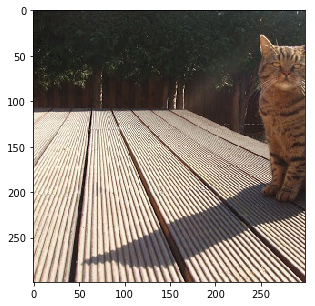

In [33]:
print(labels)
postp_image = image_utils.postprocessing(my_image)
image_utils.show_image(postp_image)


In [34]:
tf.keras.backend.clear_session() 

In [47]:
size = 299
feed_dict = {'a': 1, 
             'b' : 2}

In [68]:
# Note: batch size is always ommited, but during compilation additional
# dimension on the left is added

# clear previous session
tf.keras.backend.clear_session() 

# declare input image
original_image = keras.Input(shape=(299, 299, 3), name='original_img')

# declare parameters
params = keras.Input(shape=(1,), name='parameters')

# declare patch
patch = tf.Variable(tf.zeros(shape=(size, size, 3)), dtype=tf.float32, name='patch')

# construct adversarial image

adv_image = tf.keras.layers.add((original_image, patch))


# declare inception
incv3 = tf.keras.applications.InceptionV3(include_top=True, input_tensor=adv_image, weights='imagenet')

# declare output
output = incv3.output

# compile the model
model = keras.Model(inputs=[original_image, params],
                    outputs=output)

ValueError: A merge layer should be called on a list of inputs.

In [44]:
# clear previous session
tf.keras.backend.clear_session() 


input1 = tf.keras.layers.Input(shape=(299, 299, 3))
input2 = tf.keras.layers.Input(shape=(299, 299, 3))


patch = tf.keras.backend.variable(tf.zeros(shape=(299, 299, 3)))
print(patch.shape)

multiple_patches = tf.broadcast_to(patch, (tf.shape(input1)[0], 299, 299, 3))
print(multiple_patches.shape)

added = tf.keras.layers.add([input1, input2], name="add_inputs_together")
print(added)

added = tf.keras.layers.add([added, multiple_patches], name="add_variable")
print(added)



incv3 = tf.keras.applications.InceptionV3(include_top=True, input_tensor=added, weights=None)
incv3.trainable = False

# declare output
out = incv3.output



model1 = keras.models.Model(inputs=[input1, input2], outputs=out)


(299, 299, 3)
(None, 299, 299, 3)
Tensor("add_inputs_together/Identity:0", shape=(None, 299, 299, 3), dtype=float32)
Tensor("add_variable/Identity:0", shape=(None, 299, 299, 3), dtype=float32)


In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(4,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
______________________________________________________________________________________________

In [10]:
keras.utils.plot_model(model, 'my_first_model_with_shape_info.png', show_shapes=True)

In [24]:
preds = model.predict([np.zeros((1, 299,299,3)), np.zeros((1, 299,299,3))])
with tf.GradientTape() as tape:
    loss = preds[0][0]

grad = tape.gradient(loss, patch)
print(grad[0])

TypeError: Cannot convert value 0.00043101542 to a TensorFlow DType.

In [36]:
model.layers[-1].trainable_weights.extend([patch])

model.compile(optimizer=keras.optimizers.RMSprop(),  # Optimizer
              # Loss function to minimize
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              # List of metrics to monitor
              metrics=['sparse_categorical_accuracy'])

In [41]:
print(tf.trainable_variables)

AttributeError: module 'tensorflow' has no attribute 'trainable_variables'